In [252]:
import csv
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report,mean_squared_error
from sklearn import metrics

import scipy as sp
from sklearn.utils.class_weight import compute_class_weight
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 


%matplotlib inline



In [52]:
data = pd.read_csv('marketing_training.csv')
data_test =  pd.read_csv('marketing_test.csv')
data.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


In [71]:

#simple class to adjust the values of certain columns
class AdjustValues(BaseEstimator,TransformerMixin):
    def __init__(self,target_columns):
        self.target_columns = target_columns
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        for c in self.target_columns:
            X.loc[X[c] == 999, [c]] = 0
        return X.values
    

In [373]:
#create our data pipelines
cat_cols = ['marital','schooling','default','housing','loan','contact','day_of_week','poutcome']
num_cols = ['custAge','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','pmonths','pastEmail']
drop_cols = ['profession','month']
target_cols = ['responded']

num_pipeline = Pipeline([
        ('adjust_999_values',AdjustValues(['pdays','pmonths'])),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="constant",fill_value='unknown')),
        ('one_hot_encoding',  OneHotEncoder(handle_unknown='ignore')),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ])

In [711]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=32)

for train_index,test_index in split.split(data,data["responded"]):
    train_set_strat = data.loc[train_index]
    test_set_strat = data.loc[test_index]
    

data_prepared = full_pipeline.fit(data)

data_features = train_set_strat.drop(target_cols, axis=1)
data_targets = train_set_strat.drop(num_cols+cat_cols+drop_cols,axis=1)

test_features = test_set_strat.drop(target_cols, axis=1)
test_targets = test_set_strat.drop(num_cols+cat_cols+drop_cols,axis=1)

x_train = full_pipeline.transform(data_features)
y_train = np.asarray(data_targets)


x_test = full_pipeline.transform(test_set_strat)
y_test = np.asarray(test_targets)

y_test_bool = (y_test=='yes')
y_train_bool = (y_train=='yes')

#generate class weights
bias_weight =  float(sum(train_set_strat['responded'] == 'no')/ float(sum(train_set_strat['responded'] == 'yes')))
class_weights = compute_class_weight('balanced', np.unique(y_train), [x[0] for x in y_train])
class_weights = dict(enumerate(class_weights))
class_weights[1]=class_weights[1]




In [27]:
import keras
from keras import models
from keras import layers

from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [ ]:
#define some of our metrics
THRESHOLD = 0.5

def precision(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    return precision


def recall(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))

    recall = tp / (tp + fn)
    return recall


def fbeta(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 

In [708]:
#define our model
def create_model():

    model = models.Sequential()
    model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),
                           activation='relu', input_shape=(43,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dropout(0.32))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[fbeta,precision,recall,'accuracy'])
    
    return model


In [715]:
#perform K-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
acc_scores = []
recall_scores=[]
histories = []
saved_models = []
X = x_train
Y= y_train_bool

for train, test in kfold.split(X, Y):
  # create model
    m = create_model()
    # Fit the model
    history = m.fit(X[train], Y[train], epochs=100, batch_size=512, verbose=0,class_weight=class_weights)
    saved_models.append(m)
    histories.append(history)
    
    # evaluate the model
    scores = m.evaluate(X[test], Y[test], verbose=0)
    
    print("%s: %.2f%%\t%s: %.2f%%" % (m.metrics_names[4], scores[4]*100,'recall', scores[3]*100)) 
    acc_scores.append(scores[4] * 100)
    recall_scores.append(scores[3] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(recall_scores), np.std(recall_scores)))

acc: 78.11%	recall: 60.82%
acc: 79.80%	recall: 64.40%
acc: 78.08%	recall: 71.94%
acc: 80.44%	recall: 68.38%
acc: 80.78%	recall: 65.84%
acc: 80.94%	recall: 61.82%
acc: 78.41%	recall: 71.20%
acc: 79.43%	recall: 69.12%
acc: 78.58%	recall: 64.14%
acc: 74.32%	recall: 61.26%
78.89% (+/- 1.84%)
65.89% (+/- 3.88%)


In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

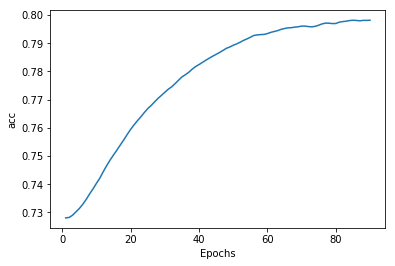

In [723]:
#performing some analysis on cross validation
sc = 'acc'
num_epochs = len(histories[0].history[sc])
average_history = [np.mean([x[i] for x in [s.history[sc] for s in histories]]) for i in range(num_epochs)]
smooth_history = smooth_curve(average_history[10:])

plt.plot(range(1, len(smooth_history) + 1), smooth_history)
plt.xlabel('Epochs')
plt.ylabel(sc)
plt.show()

In [718]:
final_model = KerasClassifier(build_fn=create_model, 
                           epochs=100, 
                           batch_size=512, 
                           verbose=0)

final_model.fit(x_train,y_train,class_weight=class_weights)

In [719]:
y_train_pred = final_model.predict(x_train)
c_matrix = confusion_matrix(y_train,y_train_pred)
print c_matrix

[[4372  887]
 [ 219  453]]


In [720]:
y_test_pred = final_model.predict(x_test)
c_matrix = confusion_matrix(y_test,y_test_pred)
print c_matrix


[[1079  236]
 [  58  110]]


In [721]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

          no       0.95      0.83      0.89      5259
         yes       0.34      0.67      0.45       672

   micro avg       0.81      0.81      0.81      5931
   macro avg       0.65      0.75      0.67      5931
weighted avg       0.88      0.81      0.84      5931



In [722]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

          no       0.95      0.82      0.88      1315
         yes       0.32      0.65      0.43       168

   micro avg       0.80      0.80      0.80      1483
   macro avg       0.63      0.74      0.65      1483
weighted avg       0.88      0.80      0.83      1483



In [691]:
#create predictions and save them to CSV

to_predict = pd.read_csv('marketing_test.csv')

X = full_pipeline.transform(to_predict)
Y = final_model.predict(X)

out_data = to_predict.copy()
out_data['responded'] = Y
out_data.to_csv('predicted_values.csv')